[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Harvard-CS1090/2026_CS1090B_public/blob/main/sec03/cs1090b_sec03_solutions_alternative.ipynb)

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">

# CS1090B Section 3 (alternative): Regularization and Data Augmentation

**Harvard University**<br/>
**Spring 2026**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb<br/>

## Overview

In this section, we investigate a central question in deep learning:

> **Why do neural networks overfit, and how can we systematically improve generalization?**

We approach this question in two stages.

---

### Part 1: Understanding Regularization (Regression Setting)

We begin with a controlled synthetic regression problem where overfitting is easy to observe and diagnose. In this setting, we:

- Visualize how overfitting emerges in training vs. validation loss curves  
- Examine how model capacity affects generalization  
- Compare four regularization strategies:
  - Early stopping  
  - L1 and L2 weight penalties  
  - Dropout  
  - Gaussian noise augmentation  

The goal is not just to apply these techniques, but to understand **how each one constrains the model** and why that improves generalization.

---

### Part 2: Regularization in Practice (Image Classification)

We then move to a more realistic setting: image classification on Fashion-MNIST.

Here, we:

- Train a neural network under limited data conditions  
- Observe overfitting in a high-dimensional input space  
- Apply image-based data augmentation (flips, rotations, noise)  

This allows us to see how augmentation acts as an *implicit regularizer* by modifying the effective training distribution.

---

### Team Activity

Finally, you will combine multiple regularization and augmentation strategies to improve validation performance.

The objective is to move beyond “plug-and-play” techniques and develop intuition for:

- When regularization is necessary  
- Which strategies are appropriate  
- How different methods interact  

## Learning Objectives

By the end of this section, you should be able to:

### Conceptual Understanding
1. Define overfitting and explain how it appears in training vs. validation loss curves.
2. Explain why regularization improves generalization.
3. Compare different regularization techniques and describe how they constrain model capacity.
4. Understand data augmentation as implicit regularization.

### Practical Skills (PyTorch + Modeling)
5. Implement and train a neural network in PyTorch for regression and classification tasks.
6. Diagnose overfitting using learning curves.
7. Apply and compare the following regularization methods:
   - L1 / L2 weight penalties
   - Early stopping
   - Dropout
   - Gaussian noise augmentation
8. Modify optimizers to include weight decay.
9. Use dropout correctly during training and inference.
10. Implement data augmentation for image classification using torchvision transforms.

## Setup: Download Data

In [1]:
#@title Colab Setup
# Environment detection and setup
import os
import subprocess
import sys
import shutil

# Define the zip file URL and expected directories
assets_zip_url = "https://github.com/Harvard-CS1090/2026_CS1090B_public/raw/main/sec03/notebook_assets.zip"

assets_zip_name = "notebook_assets.zip"
expected_dirs = ["data", "fig"]

# Check if required directories already exist
all_dirs_exist = all(os.path.isdir(d) for d in expected_dirs)

if all_dirs_exist:
    print("Required directories already exist. Skipping download.")
else:
    print(f"Downloading {assets_zip_name} from GitHub...")

    # Use wget in Colab, or urllib for local
    try:
        if 'google.colab' in sys.modules:
            subprocess.run(['wget', '-q', assets_zip_url], check=True)
        else:
            import urllib.request
            urllib.request.urlretrieve(assets_zip_url, assets_zip_name)
        print(f"Downloaded {assets_zip_name}.")

        # Unzip the file
        import zipfile
        with zipfile.ZipFile(assets_zip_name, 'r') as zip_ref:
            zip_ref.extractall('.')
        print(f"Extracted {assets_zip_name}.")

        # Clean up the zip file
        os.remove(assets_zip_name)
        print(f"Removed {assets_zip_name}.")

        # Remove __MACOSX folder if it exists
        if os.path.isdir('__MACOSX'):
            shutil.rmtree('__MACOSX')
            print("Removed __MACOSX folder.")

    except Exception as e:
        print(f"Error during setup: {e}", file=sys.stderr)

print("Setup complete!")

Required directories already exist. Skipping download.
Setup complete!


## Part 1: Regularization for Regression

When a model fits the training data too closely - capturing noise rather than the underlying pattern - it **overfits**, performing well on training examples but poorly on unseen data. Regularization techniques address this by constraining the model in various ways.

In this section, we'll intentionally overfit a neural network on a regression task, then apply different regularization techniques to combat it: early stopping, L1/L2 weight penalties, dropout, and data augmentation via Gaussian noise. We'll compare how each method affects the training and validation loss curves.

In [2]:
#@title Imports, Device Setup, and Random Seeds
import copy
import os
import random as rn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torchvision import datasets, transforms

sns.set_style('whitegrid')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(109)
rn.seed(109)
torch.manual_seed(109);

Using device: cpu


**Dataset:** We are using a synthetic dataset based on the function  
$$y = x \sin(x)$$

with added Gaussian noise.  

The exact functional form is not the focus here. What matters is that the relationship between input and output is **nonlinear** and **noisy**, which makes it an ideal setting for observing overfitting and testing regularization strategies.

Because the signal is structured but imperfect, the model can either:
- Learn the underlying pattern, or  
- Start memorizing noise  

In [3]:
#@title Generating a (Noisy) Toy Dataset: $f(x)= x\text{sin}(x)$
# We'll model noisy data from the function f(x) = x * sin(x)
def f(x):
    return x * np.sin(x)

N = 25
x = np.linspace(0, 5, N) # small, equally spaced data points for simplicity
y = f(x) + np.random.normal(0, 0.5, len(x)) # noisy data
df = pd.DataFrame({'x': x, 'y': y})

# Split to train and val (no test for our examples)
x_train, x_val, y_train, y_val = train_test_split(
    df['x'],
    df['y'],
    train_size=0.7,
    random_state=109
)

# We'll use standardized data for input to the NN
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train.to_frame()).ravel()
x_val_std = scaler.transform(x_val.to_frame()).ravel()
print(f"Generated {N} data points!")

# Torch models will want torch tensor objects
x_train_t = torch.tensor(x_train_std, dtype=torch.float32).unsqueeze(1).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
x_val_t = torch.tensor(x_val_std, dtype=torch.float32).unsqueeze(1).to(device)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

Generated 25 data points!


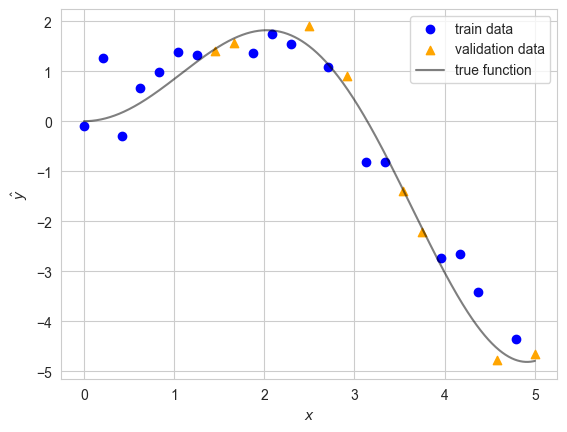

In [4]:
#@title Visualizing the Data
x_lin = np.linspace(0, 5, 1000) # large linspace for plotting

def plot_data_with_true_fn(df, idx, ax=None):
    if ax is None:
        ax = plt.gca()
    train_mask = np.ones(df.shape[0], dtype=bool)
    train_mask[idx] = False
    ax.scatter(df.x[train_mask], df.y[train_mask], c='b', label='train data')
    ax.scatter(df.x[~train_mask], df.y[~train_mask], c='orange', marker='^', label='validation data')
    ax.plot(x_lin, f(x_lin), label="true function", alpha=0.5, c='k')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\hat{y}$')
    ax.legend()

plot_data_with_true_fn(df, idx=x_val.index)

We will start with a small neural network and intentionally overfit. Below we define a baseline model using `nn.Sequential` and reusable plotting utilities that we'll use throughout Part 1 to compare different regularization strategies.

In [5]:
torch.manual_seed(109)
model1 = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        ).to(device)

optimizer = optim.Adam(model1.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 2000
history1 = {'loss': [], 'val_loss': []}
for epoch in range(epochs):
    model1.train()
    optimizer.zero_grad()
    preds_train = model1(x_train_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    model1.eval()
    with torch.no_grad():
        preds_val = model1(x_val_t)
        loss = criterion(preds_val, y_val_t)
        val_loss = loss.item()

    history1['loss'].append(train_loss)
    history1['val_loss'].append(val_loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: train loss = {train_loss:.4f}, \
              val loss = {val_loss:.4f}")

Epoch    0: train loss = 3.6419,               val loss = 6.1221
Epoch  100: train loss = 0.1060,               val loss = 0.2012
Epoch  200: train loss = 0.0830,               val loss = 0.2401
Epoch  300: train loss = 0.0094,               val loss = 0.2119
Epoch  400: train loss = 0.0045,               val loss = 0.2385
Epoch  500: train loss = 0.0027,               val loss = 0.2417
Epoch  600: train loss = 0.0017,               val loss = 0.2032
Epoch  700: train loss = 0.0005,               val loss = 0.2042
Epoch  800: train loss = 0.0011,               val loss = 0.1910
Epoch  900: train loss = 0.0001,               val loss = 0.1954
Epoch 1000: train loss = 0.0005,               val loss = 0.2114
Epoch 1100: train loss = 0.0000,               val loss = 0.2127
Epoch 1200: train loss = 0.0000,               val loss = 0.2132
Epoch 1300: train loss = 0.0094,               val loss = 0.1722
Epoch 1400: train loss = 0.0000,               val loss = 0.2129
Epoch 1500: train loss = 

> **❓ Question 1: Understanding the Training Loop**
>
> Examine the training code above and explain what each of the following does:
>
> 1. `optimizer = optim.Adam(model1.parameters(), lr=0.01)`
> 2. `criterion = nn.MSELoss()`
> 3. `loss.backward()` and `optimizer.step()`


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. `model1.parameters()` tells the optimizer which weights to update. `optim.Adam` is the adaptive gradient-based optimization algorithm. `lr=0.01` is the learning rate, which controls the step size of updates. The optimizer **does not compute gradients** — it only updates parameters using gradients that were already computed.
>
> 2. `MSELoss` computes the mean squared error between predictions and targets. It measures how far predictions are from the true values and is appropriate for regression problems. The loss function defines **what we are minimizing**.
>
> 3. `loss.backward()` computes gradients of the loss with respect to all model parameters using automatic differentiation. `optimizer.step()` updates the model parameters using those gradients. Together they form the core of one full training step: (1) forward pass → compute predictions, (2) compute loss, (3) backward pass → compute gradients, (4) optimizer step → update weights.

</details>

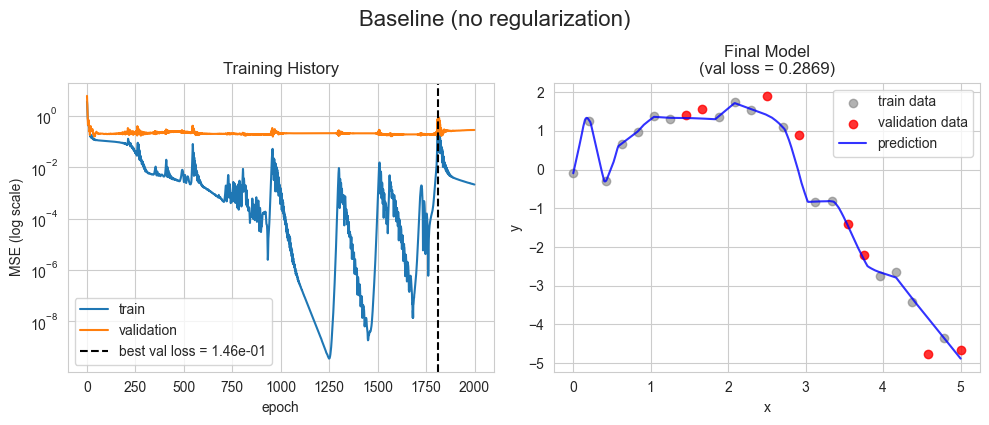

In [6]:
#@title Initial Training Results

# Some helper functions we'll use throughout for plot training results
def plot_history(history, title=None, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.plot(history['loss'], label='train')
    ax.plot(history['val_loss'], label='validation')

    ax.set_yscale('log')  # <-- log scale for MSE

    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE (log scale)')

    best_loss = np.nanmin(history['val_loss'])
    best_epoch = np.nanargmin(history['val_loss'])
    ax.axvline(best_epoch, c='k', ls='--',
               label=f'best val loss = {best_loss:.2e}')

    ax.legend()

    if title:
        ax.set_title(title)
    else:
        ax.set_title("Training History")

def plot_predictions(model, ax=None):
    if ax is None:
        ax = plt.gca()
    model.eval()
    x_lin = np.linspace(df.x.min(), df.x.max(), 500).reshape(-1, 1)
    x_lin_std = scaler.transform(pd.DataFrame(x_lin, columns=['x']))
    with torch.no_grad():
        x_tensor = torch.tensor(x_lin_std, dtype=torch.float32).to(device)
        preds = model(x_tensor).detach().cpu().numpy()
        preds_val = model(x_val_t)
    ax.plot(x_lin, preds, c='blue', alpha=0.8, label='prediction')
    ax.legend()
    # Here we reference criterion which is out of function scope.
    # This is bad practice but it makes the function calls simpler
    # and we never change the definition of criterion throughout
    # part 1.
    final_val_loss = criterion(preds_val, y_val_t).item()
    ax.set_title(f"Final Model\n(val loss = {final_val_loss:.4f})")

def plot_data(df, idx=None, ax=None):

    if ax is None:
        ax = plt.gca()

    # If validation indices are provided, separate train and val
    if idx is not None:
        train_df = df.drop(idx)
        val_df = df.loc[idx]

        ax.scatter(train_df['x'], train_df['y'],
                   color='gray', alpha=0.6, label='train data')
        ax.scatter(val_df['x'], val_df['y'],
                   color='red', alpha=0.8, label='validation data')
    else:
        ax.scatter(df['x'], df['y'],
                   color='gray', alpha=0.6, label='data')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

def plot_results(model, history, title="Model Performance"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    plot_history(history, ax=axs[0])
    plot_data(df, idx=x_val.index, ax=axs[1])
    plot_predictions(model, ax=axs[1])
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.show()

plot_results(model1, history1, "Baseline (no regularization)")

> **❓ Question 2: Diagnosing Overfitting**
>
> 1. What do you notice about the gap between training and validation loss as epochs increase?
> 2. Why does the validation loss start to increase even as training loss continues to decrease?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. The gap between training and validation loss grows larger as epochs increase. Early in training, both losses decrease together. But after some point, training loss continues to fall while validation loss levels off and then starts to rise - the curves diverge.
>
> 2. The model is memorizing the training data, including its noise, rather than learning the true underlying pattern. As training continues, the network fits the training points more and more precisely (reducing training loss), but these overly specific fits don't generalize to the validation data. The validation loss rises because the model's predictions become tuned to quirks of the training set that don't exist in the validation set.

</details>

### Weight Decay (L2) and L1 Regularization

Weight penalties add a cost to having large weights, discouraging the model from fitting noise. **L2 regularization** (weight decay) adds $\lambda \sum w^2$ to the loss, which shrinks all weights toward zero but rarely makes them exactly zero. **L1 regularization** adds $\lambda \sum |w|$ to the loss, which encourages *sparsity* - pushing many weights to exactly zero while keeping a few large ones. In practice, L2 produces smoother models while L1 can act as a form of feature selection.

**Note:** PyTorch also provides `torch.optim.AdamW`, which applies weight decay *directly* to the weights rather than through the gradient. In standard `Adam`, the penalty gets scaled down by the adaptive learning rate, weakening it for frequently-updated parameters. `AdamW` avoids this and is preferred in modern practice (e.g., transformer fine-tuning). For this small example the difference is negligible.

Epoch    0: train loss = 3.6125,               val loss = 5.3514
Epoch  100: train loss = 0.1263,               val loss = 0.2278
Epoch  200: train loss = 0.1283,               val loss = 0.2438
Epoch  300: train loss = 0.1271,               val loss = 0.2347
Epoch  400: train loss = 0.1263,               val loss = 0.2500
Epoch  500: train loss = 0.1313,               val loss = 0.2445
Epoch  600: train loss = 0.1244,               val loss = 0.2414
Epoch  700: train loss = 0.1241,               val loss = 0.2464
Epoch  800: train loss = 0.1278,               val loss = 0.2312
Epoch  900: train loss = 0.1302,               val loss = 0.2322
Epoch 1000: train loss = 0.1302,               val loss = 0.2329
Epoch 1100: train loss = 0.1227,               val loss = 0.2325
Epoch 1200: train loss = 0.1231,               val loss = 0.2220
Epoch 1300: train loss = 0.1233,               val loss = 0.2325
Epoch 1400: train loss = 0.1230,               val loss = 0.2332
Epoch 1500: train loss = 

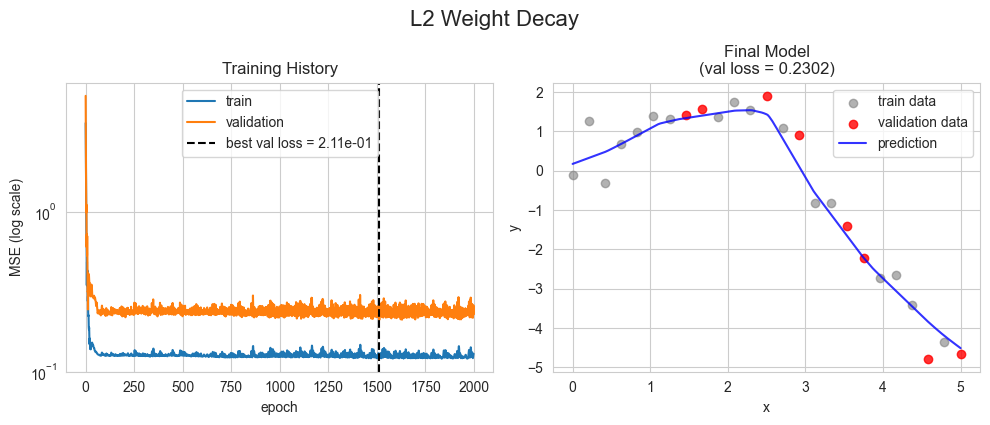

In [7]:
model2 = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        ).to(device)
# NOTE: For our optimizer we use AdamW and a new argument, `weight_decay`
# This value is high because our model (~20k parameters) vastly outnumbers
# our training data (17 points). Typical values for normal-sized datasets
# are 0.001–0.01; here we need strong regularization to prevent overfitting.
PENALTY = 3
optimizer = optim.AdamW(model2.parameters(), lr=0.01, weight_decay=PENALTY)
criterion = nn.MSELoss()

epochs = 2000
history2 = {'loss': [], 'val_loss': []}
for epoch in range(epochs):
    model2.train()
    optimizer.zero_grad()
    preds_train = model2(x_train_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    model2.eval()
    with torch.no_grad():
        preds_val = model2(x_val_t)
        loss = criterion(preds_val, y_val_t)
        val_loss = loss.item()

    history2['loss'].append(train_loss)
    history2['val_loss'].append(val_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: train loss = {train_loss:.4f}, \
              val loss = {val_loss:.4f}")

plot_results(model2, history2, "L2 Weight Decay")

> **❓ Question 3: Regularization Strength**
>
> 1. What do you expect to happen if `weight_decay` becomes very large? Think about: what happens to model capacity, what kind of functions the network can represent, and what happens to training and validation loss.
> 2. If too little regularization leads to overfitting and too much leads to underfitting, how do we choose the right `weight_decay`?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. If the penalty becomes very large, the model will be forced to keep weights close to zero. The network becomes less flexible and may **underfit** the data. Training loss will remain high, and validation loss may also remain high. In the extreme case, the model approaches a nearly linear (or flat) function.
>
>    💡 Regularization is a balance: too little → overfitting, too much → underfitting. The goal is to find the sweet spot.
>
> 2. We monitor **validation loss**. Train the model with different values of `weight_decay`, evaluate performance on held-out validation data, and choose the value that minimizes validation loss. This is the core idea behind **hyperparameter tuning** and **cross-validation**. We do not optimize regularization strength on the training set — we use validation performance to guide the choice.

</details>

---

📝 **Note on L1 Regularization**

Unlike L2 (which can be added directly using `weight_decay` in optimizers like `AdamW`),  
there is **no built-in simple argument for L1 regularization** in PyTorch optimizers.

Instead, we implement L1 manually by adding an extra penalty term to the loss:

$$
\text{loss} = \text{original loss} + \lambda \sum |w|
$$

In practice, this means:

- Compute the standard loss (e.g., MSE).
- Compute the L1 penalty by summing the absolute values of the weights.
- Add the penalty to the loss before calling `backward()`.

Here is a minimal reference implementation:

```python

l1_lambda = 0.005
# Inside the training loop, after computing the standard loss:
loss = criterion(preds, targets)
# Add L1 penalty on weights only (not biases — standard convention)
l1_penalty = sum(p.abs().sum() for name, p in model.named_parameters() if 'weight' in name)
loss = loss + l1_lambda * l1_penalty

loss.backward()
optimizer.step()
```

---

### Early Stopping

Early stopping monitors validation loss during training and halts the process when performance stops improving. The idea is simple: as training continues, the model begins to memorize noise in the training data, causing validation loss to rise even as training loss keeps falling. By saving the best model and stopping once validation loss hasn't improved for a set number of epochs (*patience*), we get a model that generalizes better without needing to tune a regularization hyperparameter directly.

Training model with Early Stopping (direct implementation)...
Epoch    0: train loss = 3.6419, val loss = 6.1221
Epoch  100: train loss = 0.1060, val loss = 0.2012
Early stopping triggered at epoch 137. Validation loss did not improve for 100 epochs.


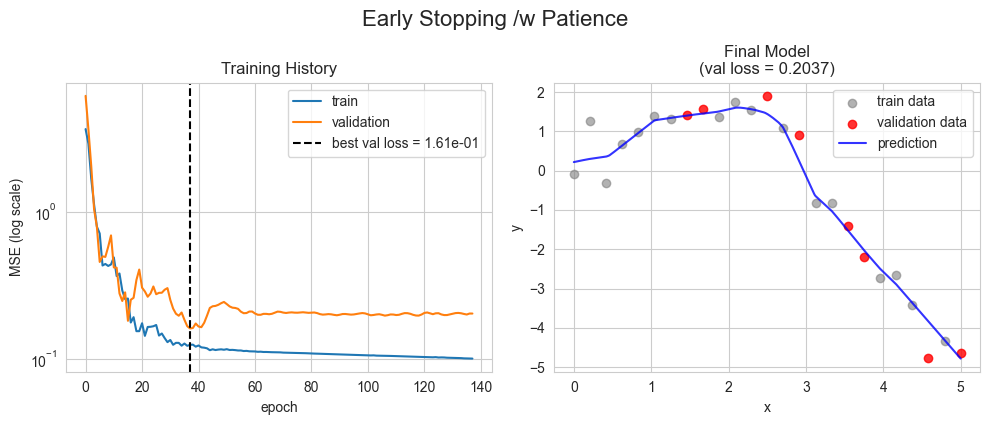

In [8]:
# Model with Early Stopping
torch.manual_seed(109)
model3 = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        ).to(device)

optimizer = optim.Adam(model3.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 2000 # Max epochs to run if not stopped early
history3 = {'loss': [], 'val_loss': []}

# Early Stopping parameters
patience = 100
best_val_loss = np.inf
patience_counter = 0

print("Training model with Early Stopping (direct implementation)...")
for epoch in range(epochs):
    model3.train()
    optimizer.zero_grad()
    preds_train = model3(x_train_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    model3.eval()
    with torch.no_grad():
        preds_val = model3(x_val_t)
        loss = criterion(preds_val, y_val_t)
        val_loss = loss.item()

    history3['loss'].append(train_loss)
    history3['val_loss'].append(val_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Validation loss did not improve for {patience} epochs.")
        break

# Plotting results for the early stopped model
plot_results(model3, history3, "Early Stopping /w Patience")

> **❓ Question 4: Understanding Early Stopping**
>
> Read the training loop carefully and think about the following:
>
> 1. What is the role of `best_val_loss`? Why is it initialized to `np.inf`? What does it track during training?
> 2. What does `patience = 100` mean? What happens if patience is very small? What happens if patience is very large?
> 3. Why do we reset `patience_counter` when validation loss improves?
> 4. Why do we monitor **validation loss** and not training loss? What would happen if we stopped based on training loss instead?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. `best_val_loss` tracks the lowest validation loss seen so far. It is initialized to `np.inf` so that any finite loss will count as an improvement on the first epoch. During training, it is updated whenever the current validation loss beats the previous best.
>
> 2. `patience = 100` means we allow up to 100 consecutive epochs without improvement before stopping. If patience is very small, training may halt prematurely before the model has had a chance to escape a temporary plateau. If patience is very large, we may continue training well past the point of overfitting, wasting compute and potentially degrading the final model.
>
> 3. Resetting `patience_counter` when validation loss improves means we only count *consecutive* epochs without improvement. A single improvement resets the countdown, giving the model a fresh window to keep learning.
>
> 4. Training loss almost always decreases — it won't signal overfitting. Validation loss reflects generalization: when it starts rising, the model is memorizing training noise. Stopping based on training loss would never trigger early stopping, defeating its purpose.
>
> 💡 **Key idea:** Early stopping is a form of *implicit regularization*. We do not constrain the weights directly — we constrain how long the model is allowed to train.

</details>

> **❓ Question 5: Best Model Restoration**
>
> When early stopping is triggered, we stop training — but are we using the model from the **last epoch before stopping**, or the model that achieved the **lowest validation loss**? Are these always the same? What is best practice?


<details>
<summary><em>Click to reveal answer</em></summary>

> These are **not** always the same. In the implementation above (cell with `model3`), we are using the model at the stopping epoch — which is `patience` epochs *after* the best validation loss was achieved. The model may have degraded during those extra epochs.
>
> Best practice is to **save the model state** whenever validation loss improves and **restore the best-performing model** after training ends. Otherwise, we stop after performance has already degraded slightly. Early stopping should return the best validation model, not simply the last one trained. The next code cell demonstrates this improved approach.

</details>

### Restoring Our Best Model

Training model with Early Stopping (direct implementation)...
Epoch    0: train loss = 3.6419, val loss = 6.1221
Early stopping triggered at epoch 25. Validation loss did not improve for 10 epochs.
Restored model to best state.


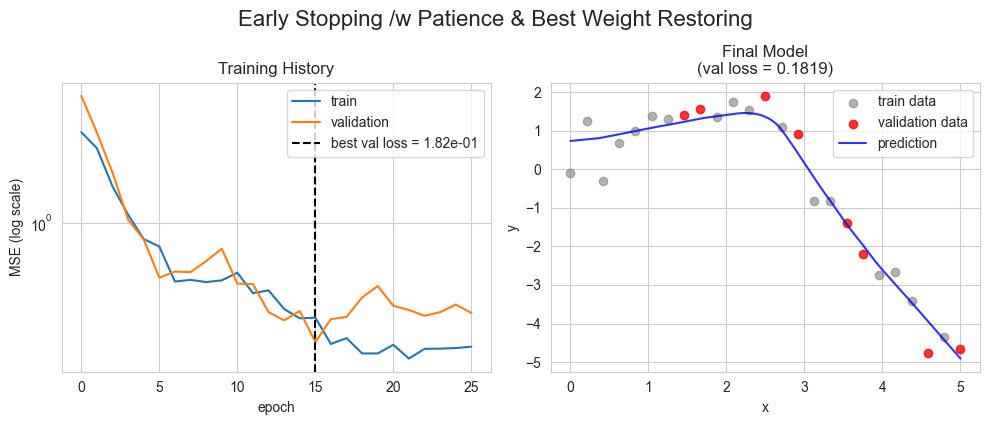

In [9]:
# Model with Early Stopping
torch.manual_seed(109)
model4 = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        ).to(device)

optimizer = optim.Adam(model4.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 2000 # Max epochs to run if not stopped early
history4 = {'loss': [], 'val_loss': []}

# Early Stopping parameters
patience = 10
best_val_loss = np.inf
patience_counter = 0
best_model_state = None

print("Training model with Early Stopping (direct implementation)...")
for epoch in range(epochs):
    model4.train()
    optimizer.zero_grad()
    preds_train = model4(x_train_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    model4.eval()
    with torch.no_grad():
        preds_val = model4(x_val_t)
        loss = criterion(preds_val, y_val_t)
        val_loss = loss.item()

    history4['loss'].append(train_loss)
    history4['val_loss'].append(val_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(model4.state_dict()) # Save the best model state
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Validation loss did not improve for {patience} epochs.")
        break

# Load the best model weights if early stopping occurred and a state was saved
if best_model_state is not None:
    model4.load_state_dict(best_model_state)
    print("Restored model to best state.")
else:
    print("No best model state to restore (perhaps val_loss never improved).")

# Plotting results for the early stopped model
plot_results(model4, history4, "Early Stopping /w Patience & Best Weight Restoring")

### Dropout

Dropout randomly zeroes a fraction of neuron activations during each training step, forcing the network to not rely on any single neuron. This acts as an implicit ensemble — on each forward pass, a different "thinned" subnetwork is active, and the final model approximates an average over all these subnetworks. At evaluation time, dropout is turned off and all neurons are active (with outputs scaled accordingly). The `dropout` parameter controls what fraction of activations are dropped (e.g., 0.3 means 30% are zeroed).

**From Lecture 4:** Dropout randomly "drops" neurons during training, forcing the network to learn redundant representations and reducing co-adaptation between neurons.

<img src=./fig/lec04_dropout_mechanism.png width="800">

Epoch    0: train loss = 3.5645,               val loss = 6.1733
Epoch  100: train loss = 0.9896,               val loss = 0.3441
Epoch  200: train loss = 0.5248,               val loss = 1.0470
Epoch  300: train loss = 0.6444,               val loss = 0.3486
Epoch  400: train loss = 0.2297,               val loss = 1.2289
Epoch  500: train loss = 0.3301,               val loss = 1.0545
Epoch  600: train loss = 0.3345,               val loss = 0.7136
Epoch  700: train loss = 0.4031,               val loss = 0.8838
Epoch  800: train loss = 0.5873,               val loss = 1.1866
Epoch  900: train loss = 0.4662,               val loss = 0.5742
Epoch 1000: train loss = 0.3823,               val loss = 0.5755
Epoch 1100: train loss = 0.6994,               val loss = 0.9333
Epoch 1200: train loss = 0.2999,               val loss = 0.7507
Epoch 1300: train loss = 0.6546,               val loss = 0.4294
Epoch 1400: train loss = 0.4207,               val loss = 0.4762
Epoch 1500: train loss = 

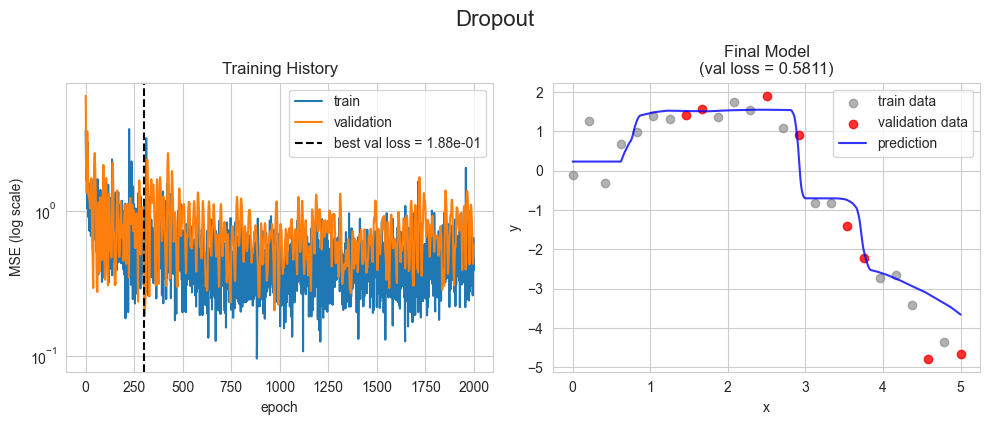

In [10]:
model5 = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 1)
        ).to(device)

optimizer = optim.Adam(model5.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 2000
history5 = {'loss': [], 'val_loss': []}
for epoch in range(epochs):
    model5.train()
    optimizer.zero_grad()
    preds_train = model5(x_train_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    model5.eval()
    with torch.no_grad():
        preds_val = model5(x_val_t)
        loss = criterion(preds_val, y_val_t)
        val_loss = loss.item()

    history5['loss'].append(train_loss)
    history5['val_loss'].append(val_loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: train loss = {train_loss:.4f}, \
              val loss = {val_loss:.4f}")

plot_results(model5, history5, "Dropout")

### Data Augmentation with Gaussian Noise

Adding random noise to inputs during training is a simple form of data augmentation that acts as a regularizer. Each time the model sees a training example, it sees a slightly perturbed version, which prevents it from memorizing exact input-output mappings. The noise is only applied during training - at evaluation time, the original clean inputs are used. This is especially useful when the dataset is small and collecting more data isn't feasible.

In [11]:
# This class will be utilized later when we add Gaussian noise as a model layer.
# 209 students take note!
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training and self.stddev > 0:
            noise = torch.randn_like(x) * self.stddev
            return x + noise
        return x

Epoch    0: train loss = 3.6515,               val loss = 5.8233
Epoch  100: train loss = 0.3020,               val loss = 0.2508
Epoch  200: train loss = 0.1867,               val loss = 0.2695
Epoch  300: train loss = 0.1354,               val loss = 0.2080
Epoch  400: train loss = 0.3036,               val loss = 0.3263
Epoch  500: train loss = 0.1124,               val loss = 0.2960
Epoch  600: train loss = 0.1973,               val loss = 0.2827
Epoch  700: train loss = 0.1884,               val loss = 0.1293
Epoch  800: train loss = 0.1760,               val loss = 0.2847
Epoch  900: train loss = 0.1859,               val loss = 0.0887
Epoch 1000: train loss = 0.1393,               val loss = 0.1193
Epoch 1100: train loss = 0.1469,               val loss = 0.1199
Epoch 1200: train loss = 0.1400,               val loss = 0.2968
Epoch 1300: train loss = 0.1538,               val loss = 0.2268
Epoch 1400: train loss = 0.1311,               val loss = 0.1410
Epoch 1500: train loss = 

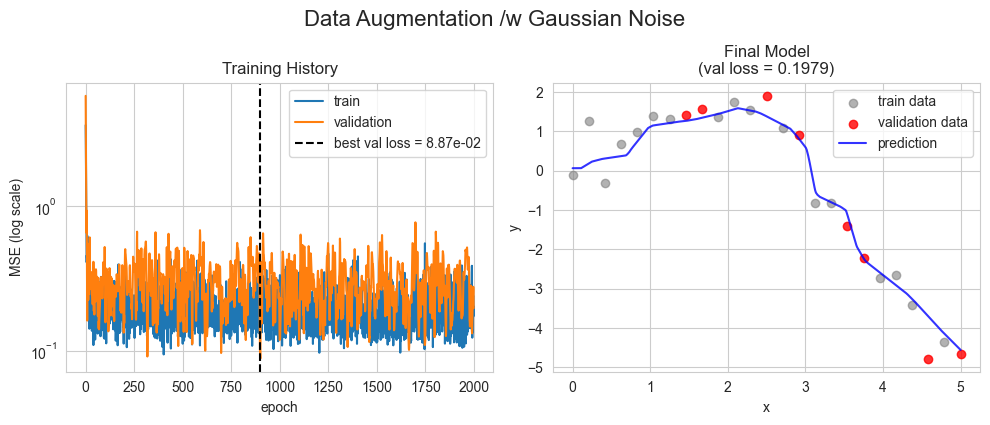

In [12]:
model6 = nn.Sequential(
            GaussianNoise(0.1),
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        ).to(device)

optimizer = optim.Adam(model6.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 2000
history6 = {'loss': [], 'val_loss': []}
for epoch in range(epochs):
    model6.train()
    optimizer.zero_grad()
    preds_train = model6(x_train_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    model6.eval()
    with torch.no_grad():
        preds_val = model6(x_val_t)
        loss = criterion(preds_val, y_val_t)
        val_loss = loss.item()

    history6['loss'].append(train_loss)
    history6['val_loss'].append(val_loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: train loss = {train_loss:.4f}, \
              val loss = {val_loss:.4f}")

plot_results(model6, history6, "Data Augmentation /w Gaussian Noise")

## Part 2: Classification with Fashion-MNIST

Having seen regularization in the regression setting, we now apply these ideas to a classification task. We'll build an MLP classifier on Fashion-MNIST, observe overfitting with limited data, and then use data augmentation to improve generalization.

---

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a drop-in replacement for MNIST.

<img src="https://4.bp.blogspot.com/-OQZGt_5WqDo/Wa_Dfa4U15I/AAAAAAAAAUI/veRmAmUUKFA19dVw6XCOV2YLO6n-y_omwCLcBGAs/s400/out.jpg" width="400px" alt="Grid of Fashion-MNIST sample images showing 10 clothing categories: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot" />

### DataLoaders (PyTorch)

We use `torchvision.datasets.FashionMNIST` with `transforms.Compose` and PyTorch DataLoaders. We'll take a small train/validation split for faster experimentation.

In [13]:
# Load Fashion-MNIST with normalization
mean, std = (0.2860,), (0.3530,)
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

fashion_train = datasets.FashionMNIST(root='data', train=True, download=True, transform=base_transform)
fashion_test = datasets.FashionMNIST(root='data', train=False, download=True, transform=base_transform)

print(fashion_train, fashion_test)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.286,), std=(0.353,))
           ) Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.286,), std=(0.353,))
           )


In [14]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


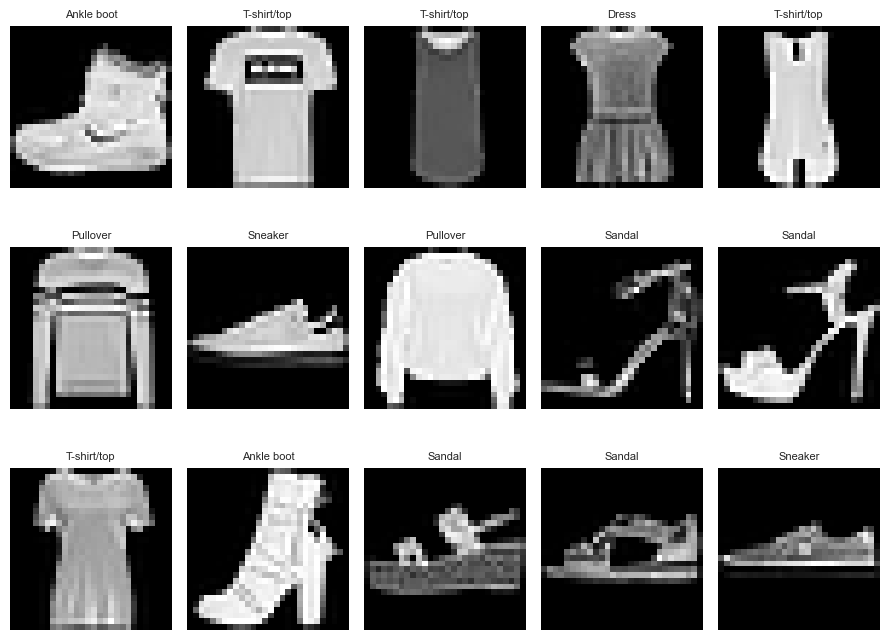

In [15]:
# Display a few examples (unnormalized for visualization)
fig, axs = plt.subplots(3, 5, figsize=(9, 7))
for i, ax in enumerate(axs.ravel()):
    image, label = fashion_train[i]
    image = image * std[0] + mean[0]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(labels[label], fontsize=8)
    ax.axis('off')
plt.tight_layout()

We will use PyTorch `Subset` objects to create train/validation/test splits without writing images to disk.

In [16]:
from torch.utils.data import Subset

# Reduce dataset sizes for faster experimentation
generator = torch.Generator().manual_seed(109)
train_size = 1200
val_size = 240
test_size = 1000

train_val_indices = torch.randperm(len(fashion_train), generator=generator)[:train_size + val_size]
train_indices = train_val_indices[:train_size].tolist()
val_indices = train_val_indices[train_size:].tolist()
test_indices = torch.randperm(len(fashion_test), generator=generator)[:test_size].tolist()

train_subset = Subset(fashion_train, train_indices)
val_subset = Subset(fashion_train, val_indices)
test_subset = Subset(fashion_test, test_indices)

In [17]:
# Create DataLoaders
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

data_batch, labels_batch = next(iter(train_loader))
print('data batch shape:', data_batch.shape)
print('labels batch shape:', labels_batch.shape)

data batch shape: torch.Size([32, 1, 28, 28])
labels batch shape: torch.Size([32])


> **❓ Question 6: Subset Splits**
>
> 1. Why do we create separate train/validation/test subsets instead of reusing the full dataset?
> 2. How could class imbalance in a small subset affect validation accuracy?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Each split serves a distinct purpose: **training data** is used to learn weights, **validation data** is used to tune hyperparameters (learning rate, regularization strength, when to stop), and **test data** provides an unbiased estimate of generalization. If we reused data across these roles, our estimates would be optimistically biased - we'd be evaluating on data the model has already seen or that influenced our choices. The test set should only be used once, after all tuning is complete, to get a fair measure of real-world performance.
>
> 2. When randomly sampling a small subset, some classes may end up over- or under-represented by chance. If the validation set has fewer examples of a difficult class, accuracy may appear artificially high. Conversely, if a rare class is over-represented, small improvements on that class can swing the overall metric. This makes validation accuracy a noisier signal for hyperparameter tuning. Stratified sampling (ensuring each class appears proportionally) can mitigate this, but with very small subsets, variance remains unavoidable.

</details>

### Build a Classifier

In [18]:
class FashionMLP(nn.Module):
    def __init__(self, input_dim=28*28, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [19]:
def train_classifier(model, train_loader, val_loader, optimizer, criterion, epochs=30, patience=None):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    # Early stopping state
    best_val_loss = np.inf
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        train_loss /= len(train_loader.dataset)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Early stopping logic
        if patience is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = copy.deepcopy(model.state_dict())
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

    # Restore best model weights
    if patience is not None and best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history


def evaluate_classifier(model, loader, criterion):
    model.eval()
    loss_total = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss_total += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return loss_total / len(loader.dataset), correct / total

In [20]:
torch.manual_seed(109)
model_cls = FashionMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cls.parameters(), lr=0.001)

history_cls = train_classifier(
    model_cls,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=30,
    patience=5
)

In [21]:
train_loss, train_acc = evaluate_classifier(model_cls, train_loader, criterion)
val_loss, val_acc = evaluate_classifier(model_cls, val_loader, criterion)
test_loss, test_acc = evaluate_classifier(model_cls, test_loader, criterion)

print(f"Train — Loss: {train_loss:.4f}, Acc: {train_acc:.2f}")
print(f"Val   — Loss: {val_loss:.4f}, Acc: {val_acc:.2f}")
print(f"Test  — Loss: {test_loss:.4f}, Acc: {test_acc:.2f}")

Train — Loss: 0.0797, Acc: 0.99
Val   — Loss: 0.5258, Acc: 0.85
Test  — Loss: 0.6862, Acc: 0.78


Val Acc at last training epoch (before best-model restore): 0.81


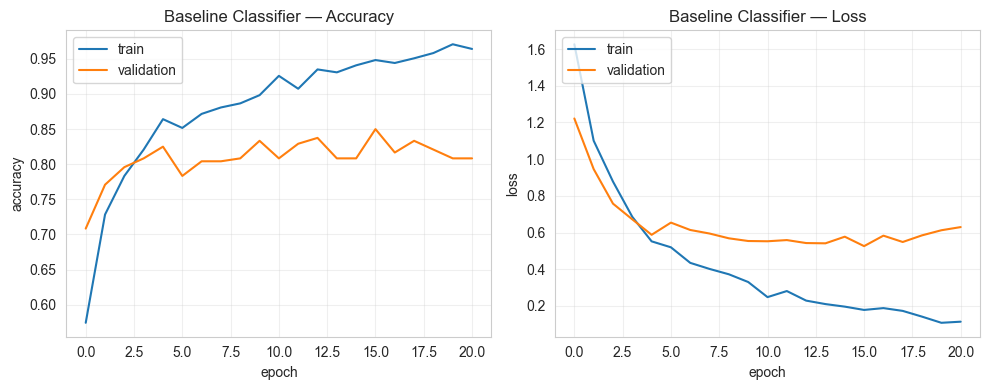

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
print(f"Val Acc at last training epoch (before best-model restore): {history_cls['val_accuracy'][-1]:.2f}")
axs[0].plot(history_cls['accuracy'])
axs[0].plot(history_cls['val_accuracy'])
axs[0].set_title('Baseline Classifier — Accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].grid(True, alpha=0.3)
axs[0].legend(['train', 'validation'], loc='upper left')

axs[1].plot(history_cls['loss'])
axs[1].plot(history_cls['val_loss'])
axs[1].set_title('Baseline Classifier — Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].grid(True, alpha=0.3)
axs[1].legend(['train', 'validation'], loc='upper left')
plt.tight_layout();

### Data Augmentation

In Part 1, we added Gaussian noise directly inside the model as a regularizer. For image data, we can go further — applying transformations that exploit known invariances. A T-shirt is still a T-shirt whether flipped horizontally or slightly rotated. By applying random transforms on-the-fly, the model sees a different variation of each image every epoch, even though the dataset itself remains 1,200 samples. Below we combine random flips, small rotations, and Gaussian noise as a `torchvision` transform pipeline.

In [23]:
class AddGaussianNoise:
    def __init__(self, std=0.05):
        self.std = std

    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn_like(tensor) * self.std, 0.0, 1.0)

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  #Default probability is 0.5
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    AddGaussianNoise(0.05),
    transforms.Normalize(mean, std)
])

fashion_train_aug = datasets.FashionMNIST(root='data', train=True, download=False, transform=augment_transform)
train_subset_aug = Subset(fashion_train_aug, train_indices)
train_loader_aug = torch.utils.data.DataLoader(train_subset_aug, batch_size=batch_size, shuffle=True)

> **❓ Question 7: Choosing Augmentations**
>
> Not all augmentations are appropriate for every dataset. Consider the transforms we used: `RandomHorizontalFlip`, `RandomRotation(10)`, and `AddGaussianNoise`.
>
> 1. Why is `RandomHorizontalFlip` a reasonable augmentation for Fashion-MNIST? For which classes (if any) might it *not* preserve the label?
> 2. Why do we limit rotation to just 10 degrees? What could go wrong with larger rotations (e.g., 90°)?
> 3. We did **not** include `RandomVerticalFlip`. Why would vertical flips be a bad augmentation for clothing images?
> 4. If you were working with a medical imaging dataset (e.g., chest X-rays), which of these augmentations would still be appropriate and which would not?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Most clothing items look plausible when mirrored left-to-right — a horizontally flipped sneaker is still a valid sneaker. For symmetric classes (T-shirt, Pullover, Coat) it's essentially a no-op. Some items with asymmetric features (e.g., a Bag with a side clasp) could look slightly different flipped, but the label stays valid.
>
> 2. Small rotations simulate natural variation in how items are photographed or worn. At 90°, a T-shirt becomes sideways - it no longer looks like a typical T-shirt image, which would add noisy/misleading training signal. The augmentation should stay within the range of plausible real-world variation.
>
> 3. Clothing is almost never seen upside-down. An upside-down ankle boot doesn't resemble any real training or test example, so vertical flips would introduce unrealistic samples that could hurt generalization rather than help it.
>
> 4. Horizontal flips may or may not be appropriate depending on anatomy (chest X-rays are roughly symmetric, so flips are often fine; but for laterality-sensitive tasks they would be harmful). Small rotations are generally safe. Gaussian noise can simulate sensor noise and is usually appropriate. An augmentation is valid only if the transformed image could plausibly appear in the real data with the same label.

</details>

In [24]:
torch.manual_seed(109)
model_cls_aug = FashionMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cls_aug.parameters(), lr=0.001)

history_aug = train_classifier(
    model_cls_aug,
    train_loader_aug,
    val_loader,
    optimizer,
    criterion,
    epochs=60,
    patience=10
)

Final epoch val Acc: 0.84
Best epoch val Acc: 0.85


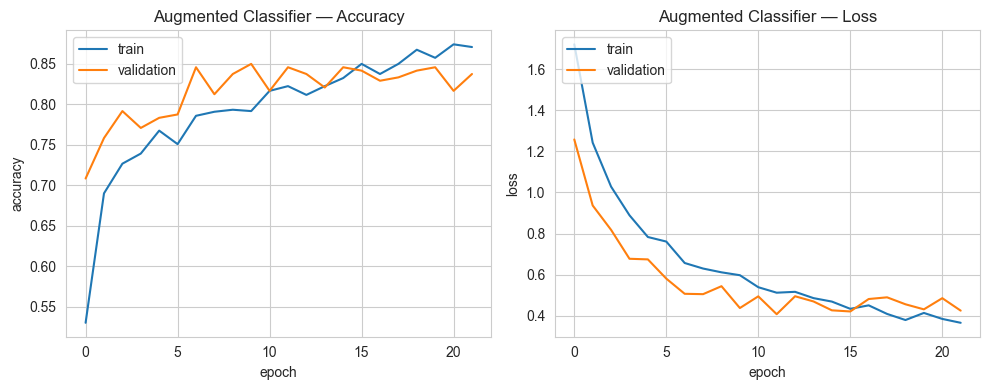

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
print(f"Final epoch val Acc: {history_aug['val_accuracy'][-1]:.2f}")
print(f"Best epoch val Acc: {max(history_aug['val_accuracy']):.2f}")

axs[0].plot(history_aug['accuracy'])
axs[0].plot(history_aug['val_accuracy'])
axs[0].set_title('Augmented Classifier — Accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

axs[1].plot(history_aug['loss'])
axs[1].plot(history_aug['val_loss'])
axs[1].set_title('Augmented Classifier — Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.tight_layout();

In [26]:
train_loss, train_acc = evaluate_classifier(model_cls_aug, train_loader, criterion)
val_loss, val_acc = evaluate_classifier(model_cls_aug, val_loader, criterion)
test_loss, test_acc = evaluate_classifier(model_cls_aug, test_loader, criterion)

print(f"Train — Loss: {train_loss:.4f}, Acc: {train_acc:.2f}")
print(f"Val   — Loss: {val_loss:.4f}, Acc: {val_acc:.2f}")
print(f"Test  — Loss: {test_loss:.4f}, Acc: {test_acc:.2f}")

Train — Loss: 0.3577, Acc: 0.87
Val   — Loss: 0.4081, Acc: 0.85
Test  — Loss: 0.6030, Acc: 0.80


**Results comparison:** Augmentation improved validation accuracy over the baseline on our small 1,200-sample training set, while test accuracy remained similar. With only 1,000 test samples, a few points of difference can be noise, and the validation split comes from the same `fashion_train` pool, so gains may not transfer to the separate test set. Always rely on a truly held-out test set and avoid over-interpreting small differences.

Note: exact metrics can vary across runs and hardware (CPU vs GPU) due to nondeterminism.

> **❓ Question 8: Model Layer vs. Data Transform for Noise**
>
> In Part 1 we added Gaussian noise as a **model layer** (`GaussianNoise(nn.Module)`), while in Part 2 we added it as a **data transform** (`AddGaussianNoise` in `transforms.Compose`). Both inject random noise during training to regularize the model.
>
> 1. At what point in the pipeline does noise get applied in each approach? How does this affect what the noise "means" (pixel space vs. normalized space)?
> 2. What are the trade-offs of each approach? When might you prefer one over the other?
> 3. The `AddGaussianNoise` transform clamps values to [0, 1]. Why is this necessary here but not in the `GaussianNoise` module?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. **Data transform (Part 2):** Noise is applied in the data loading pipeline, *after* `ToTensor()` (pixel space [0, 1]) but *before* `Normalize()`. So the noise is in raw pixel space — a std of 0.05 means ~5% of the pixel range. **Model layer (Part 1):** Noise is applied inside the model's `forward()` pass, so it acts on already-normalized inputs. The noise magnitude is relative to the normalized feature scale, not raw pixel values.
>
> 2. **Data transform pros:** Composes naturally with other image augmentations (flips, rotations, crops); keeps the model architecture clean; noise parameters are part of the data pipeline config. **Model layer pros:** Automatically disabled at eval time via `model.eval()` (no need to manage separate train/test transforms); the noise is always in the same space as the model's inputs; can be placed between any layers (not just at the input). A model layer is more convenient when you don't have a separate augmented data pipeline, or when you want noise injected at intermediate layers.
>
> 3. The transform operates in pixel space [0, 1], where values outside this range are physically meaningless (you can't have negative pixel intensity). Clamping keeps values valid before normalization. The `GaussianNoise` module operates in normalized space, where values are already unbounded (normalization maps [0, 1] to roughly [-0.81, 2.02]), so clamping would be inappropriate — it would distort the learned distribution.

</details>

---

## 🏋️ TEAM ACTIVITY: Fashion-MNIST Regularization

Try improving validation accuracy beyond 83% without changing the overall network depth. Consider tuning dropout rates, batch normalization placement, optimizers, and augmentation settings. Track your best configuration.

---

**Define an enhanced model with dropout**

Create a modified `FashionMLP` that adds dropout layers between the hidden layers. Keep the same layer sizes (256 → 128 → 64 → 32) but add `nn.Dropout` after the first two ReLU activations.

**Hint:** A dropout rate of 0.2 provides regularization without over-constraining the model. Don't add dropout to every layer.

In [27]:
# your code here
# BEGIN SOLUTION
class FashionMLPRegularized(nn.Module):
    def __init__(self, input_dim=28*28, num_classes=10, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)
# END SOLUTION

**Create augmentation with small translations**

The baseline augmentation already includes flips, rotation, and noise. Add small random translations via `RandomAffine` to simulate slightly shifted images.

**Hint:** Keep translations small (5% of image size) to avoid shifting important features out of frame.

In [28]:
# your code here
# BEGIN SOLUTION
augment_transform_v2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small shifts
    transforms.ToTensor(),
    AddGaussianNoise(0.05),
    transforms.Normalize(mean, std)
])

fashion_train_aug_v2 = datasets.FashionMNIST(root='data', train=True, download=False, transform=augment_transform_v2)
train_subset_aug_v2 = Subset(fashion_train_aug_v2, train_indices)
train_loader_aug_v2 = torch.utils.data.DataLoader(train_subset_aug_v2, batch_size=32, shuffle=True)
# END SOLUTION

**Train and evaluate**

Train your regularized model. The dropout already provides regularization, so we don't need heavy weight decay.

**Hint:** Standard Adam with `lr=0.001` works well with dropout.

In [29]:
# your code here
# BEGIN SOLUTION
torch.manual_seed(109)
model_team = FashionMLPRegularized(dropout=0.2).to(device)
optimizer = optim.Adam(model_team.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history_team = train_classifier(
    model_team,
    train_loader_aug_v2,
    val_loader,
    optimizer,
    criterion,
    epochs=100,
    patience=10
)

# Evaluate
train_loss, train_acc = evaluate_classifier(model_team, train_loader, criterion)
val_loss, val_acc = evaluate_classifier(model_team, val_loader, criterion)
test_loss, test_acc = evaluate_classifier(model_team, test_loader, criterion)

print(f"Train — Loss: {train_loss:.4f}, Acc: {train_acc:.2f}")
print(f"Val   — Loss: {val_loss:.4f}, Acc: {val_acc:.2f}")
print(f"Test  — Loss: {test_loss:.4f}, Acc: {test_acc:.2f}")
# END SOLUTION

Train — Loss: 0.3591, Acc: 0.87
Val   — Loss: 0.3894, Acc: 0.85
Test  — Loss: 0.6393, Acc: 0.77


**Plot training curves**

Plot the accuracy and loss curves for your regularized model. Compare the gap between training and validation — is it smaller than the baseline?

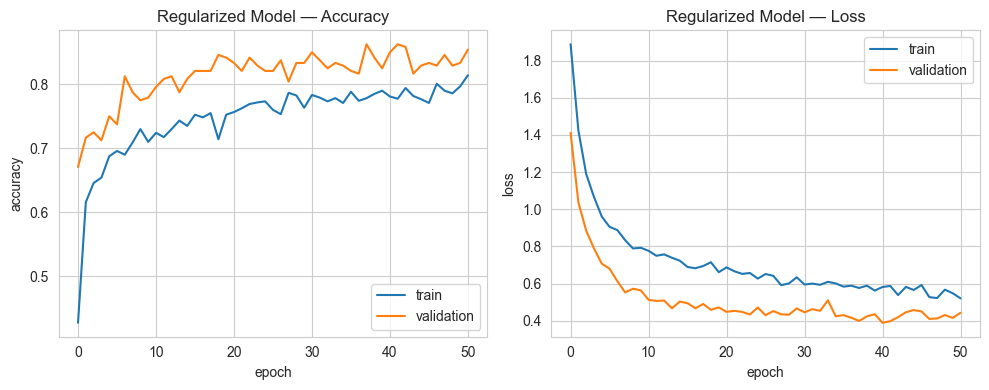

In [30]:
# your code here
# BEGIN SOLUTION
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(history_team['accuracy'], label='train')
axs[0].plot(history_team['val_accuracy'], label='validation')
axs[0].set_title('Regularized Model — Accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(history_team['loss'], label='train')
axs[1].plot(history_team['val_loss'], label='validation')
axs[1].set_title('Regularized Model — Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend()

plt.tight_layout()
# END SOLUTION

**End of team activity**

## A Note on GPU Device Management

This notebook is configured to use a GPU when available (`device = 'cuda'`), falling back to CPU otherwise. Working with GPUs in PyTorch requires explicitly moving data and models to the same device. Here's the pattern you'll see throughout:

**1. Model to device** — `model.to(device)` moves all model parameters (weights, biases, BatchNorm statistics) to the GPU. This only needs to be done once after creating the model.

**2. Batches to device** — Inside the training loop, each mini-batch must also be moved: `xb = xb.to(device)` and `yb = yb.to(device)`. DataLoaders return CPU tensors by default, so this transfer happens every iteration. If the model is on GPU but the data is on CPU (or vice versa), PyTorch will raise a runtime error.

**3. Getting results back for evaluation** — There are two separate concerns when extracting values from PyTorch tensors:

- **Computation graph**: Tensors produced during a forward pass track operations for automatic differentiation (regardless of whether they're on CPU or GPU). To disconnect from this graph, either wrap code in `torch.no_grad()` (prevents tracking entirely — used in eval loops) or call `.detach()` on individual tensors.

- **Device transfer**: GPU tensors can't be converted to NumPy arrays directly — they must first move to CPU via `.cpu()`.

In practice you'll see two patterns in this notebook:
- **Scalars** (losses, accuracy counts): use `.item()` to extract a Python number — this handles both detaching and device transfer in one call. Example from the training loop: `loss.item()`, `(preds == yb).sum().item()`.
- **Full tensors** (predictions for plotting): use `.detach().cpu().numpy()` to get a NumPy array. Example from `plot_predictions`: `preds = model(x_tensor).detach().cpu().numpy()`. Inside a `torch.no_grad()` block the `.detach()` is technically redundant, but it's common practice to include it for safety.

In short: **model and data must live on the same device**, and **results must come back to CPU** before you can use them with non-PyTorch libraries like NumPy or matplotlib.